In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results_from_dict
import numpy as np

In [479]:
df_crawled.sort_values('event_date')

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat,view_country_article
815,Q21683348,2015 Milano–Torino,2015-10-01,Global North,Italy,Europe,sports,"['Category:2015 UCI Europe Tour', 'Category:20...",554,21.000000,...,2015,30306.122125,1.835899e+12,True,2015-10-01,2.527000e+07,False,False,>10^7,10735.0
579,Q20976914,2015 Tour de Corse,2015-10-01,Global North,France,Europe,sports,['Category:2015 World Rally Championship seaso...,659,0.000000,...,2015,36611.753912,2.438208e+12,True,2015-10-01,9.448800e+07,False,False,>10^7,13390.0
11981,Q21057315,Deslizamiento de tierra en El Cambray II de 2015,2015-10-01,Global South,Guatemala,North America,disaster,"['Categoría:Desastres naturales en Guatemala',...",2800,0.000000,...,2015,3826.262816,6.218606e+10,False,2015-10-01,1.788500e+07,True,False,>10^7,3335.0
7619,Q20976914,Rallye Korsika 2015,2015-10-01,Global North,France,Europe,sports,"['Kategorie:Rallye-WM-Lauf 2015', 'Kategorie:R...",307,14.857143,...,2015,36611.753912,2.438208e+12,True,2015-10-01,6.093000e+06,False,False,>10^6,4190.0
11980,Q21036673,Masacre del Instituto Superior Umpqua de 2015,2015-10-01,Global North,United States,North America,disaster,"['Categoría:Estados Unidos en 2015', 'Categorí...",267,0.000000,...,2015,56738.091771,1.820602e+13,True,2015-10-01,6.104100e+07,False,False,>10^7,10519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Q104579536,2020 Gjerdrum landslide,2020-12-30,Global North,Norway,Europe,disaster,"['Category:2020 disasters in Europe', 'Categor...",38328,0.000000,...,2020,66870.730726,3.625223e+11,True,2020-12-01,2.763000e+07,False,False,>10^7,8266.0
11703,Q104579536,Avalancha de Gjerdrum de 2020,2020-12-30,Global North,Norway,Europe,disaster,"['Categoría:Corrimientos de tierra', 'Categorí...",24,0.000000,...,2020,66870.730726,3.625223e+11,True,2020-12-01,2.120000e+05,False,False,>10^5,2070.0
85,Q104621508,Killing of Dolal Idd,2020-12-30,Global North,United States,North America,disaster,['Category:2020 controversies in the United St...,21836,0.000000,...,2020,63122.594145,2.089375e+13,True,2020-12-01,3.166022e+09,True,True,>10^9,45086.0
84,Q104588556,2021 New Year Honours (New Zealand),2020-12-31,Global North,New Zealand,Oceania,culture,"['Category:2021 awards', 'Category:2021 in New...",1875,291.857143,...,2020,43972.130573,2.120439e+11,True,2020-12-01,4.048600e+07,True,False,>10^7,16604.0


In [3]:
df_crawled = load_preprocessed_events()
df_crawled = load_if_in_country_or_lang(df_crawled)
df_crawled = categorize_views_for_df(df_crawled)
df_crawled.event_date = pd.to_datetime(df_crawled.event_date)
df_crawled.head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False,>10^7
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False,>10^8
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False,>10^7
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False,>10^6


In [4]:
from preprocessing import replace_country_names
df_pageviews_all = pd.read_csv(f'countries/pageviews_countries.csv')
df_pageviews_all.date = pd.to_datetime(df_pageviews_all.date)
df_pageviews_all['month_year'] = df_pageviews_all.apply(lambda row: f'{row.date.year}-{row.date.month:02d}', axis=1)
df_pageviews_all['date_month'] = df_pageviews_all.apply(lambda row: pd.to_datetime(f'{row.month_year}-01'), axis=1)
replace_country_names(df_pageviews_all, inplace=True)
df_pageviews_all = df_pageviews_all.rename({view_col: view_col.replace('views_', '') for view_col in df_pageviews_all.columns if view_col.startswith('views_')}, axis=1)

In [5]:
from dateutil.relativedelta import relativedelta
def get_pageviews_baseline(row, df_pageviews, ts_months, pre_period = 0, func=np.median):
    return np.median(df_pageviews[(df_pageviews.en_article == row.country) & (df_pageviews.date >= (row.event_date - relativedelta(months=ts_months, days=pre_period))) & (df_pageviews.date < (row.event_date - relativedelta(days=pre_period)))][row.code])

df_crawled['view_country_article'] = df_crawled.apply(lambda row: get_pageviews_baseline(row, df_pageviews_all, 5), axis=1)

# Regression

In [7]:
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes

In [398]:
df_filtered = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.views_7_sum > 10)].copy()
df_filtered['GDP_pc_z'] = standardize_var(df_filtered, 'GDP_pc')
df_filtered['gdp_z'] = standardize_var(df_filtered, 'GDP')
df_filtered['pop_z'] = standardize_var(df_filtered, 'population')
df_filtered['views_baseline_z'] = standardize_var(df_filtered, 'views_baseline')
df_filtered['view_country_article_z'] = standardize_var(df_filtered, 'view_country_article')
df_filtered['bing_hits_z'] = standardize_var(df_filtered, 'bing_hits')
df_filtered['worldwide'] = df_filtered.code.apply(lambda c: (c == 'en') or (c=='es'))
df_filtered['view_country_article_log'] = np.log1p(df_filtered.view_country_article)
df_filtered['views_baseline_log'] = np.log1p(df_filtered.views_baseline)
df_filtered['bing_hits_log'] = np.log1p(df_filtered.bing_hits)
df_filtered['GDP_pc_log'] = np.log1p(df_filtered.GDP_pc)
df_filtered['GDP_log'] = np.log1p(df_filtered.GDP)
df_filtered['population_log'] = np.log1p(df_filtered.population)

baselines = {'gni_class': 'H', 'in_code_lang': True, 'gni_region': 'North America', 'cat': 'sports', 'code': 'en', 'continent': 'North America', 'economic_region': 'Global North'} #{'gni_class': 'H', 'in_code_lang': True, 'gni_region': 'North America', 'cat': 'sports', 'code': 'en'},
cat_dict = {'en': 'English', 'it': 'Italian', 'es': 'Spanish', 'de': 'German', 'economic_region': 'Global North'}
label_renames = {'Middle East & North Africa': 'MENAf', 'Latin America & Caribbean': 'LatAmC',
               'Europe & Central Asia': 'EuCAs', 'East Asia & Pacific': 'EAsP', 'North America': 'NAm',
               'Sub-Saharan Africa': 'SSAf', 'South Asia': 'SAs', 'GDP_pc_z': 'GDP pc (z.)',
                 'GDP_pc_log': 'GDP pc', 'gni_class': 'Income', 'gni_region': 'Region',
                 'bing_hits_log': 'Bing', 'view_country_article_log': 'Views to\nCountry\nArticle', 'views_baseline_log': 'Views\nfrom\nCountry',
                  'bing_hits_z': 'Bing (z)', 'view_country_article_z': 'Views to\nCountry\nArticle (z)', 'views_baseline_z': 'Views\nfrom\nCountry (z)',
                 'Global North': 'North', 'Global South': 'South'
                }
label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
              'cat': ['sports', 'disaster',
                      'culture', 'politics'],
              'gni_region': ['North America',
                             'Europe & Central Asia',
                             'Middle East & North Africa',
                             'East Asia & Pacific',
                             'South Asia',
                             'Latin America & Caribbean',
                             'Sub-Saharan Africa'],
           'continent': ['North America', 'Africa',  'Asia', 'Europe', 'Oceania', 'South America'],
           'economic_region': ['Global North', 'Global South']}

In [369]:
df_filtered.to_csv('events/df_filtered_reg.csv', index=False)

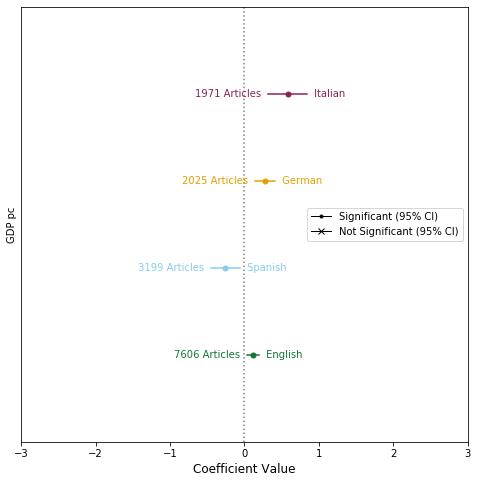

In [322]:
nb_fit_dict_0 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ GDP_pc_log', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_0, ['GDP_pc_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-3, 3))

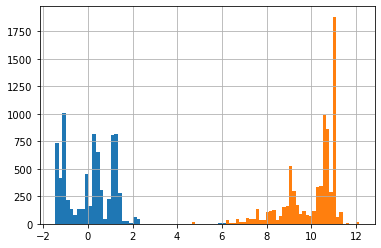

In [445]:
df_filtered[df_filtered.code == 'en'].GDP_pc_z.hist(bins=50)
df_filtered[df_filtered.code == 'en'].GDP_pc_log.hist(bins=50)

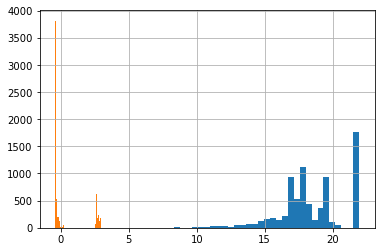

In [447]:
df_filtered[df_filtered.code == 'en'].views_baseline_log.hist(bins=50)
df_filtered[df_filtered.code == 'en'].views_baseline_z.hist(bins=50)

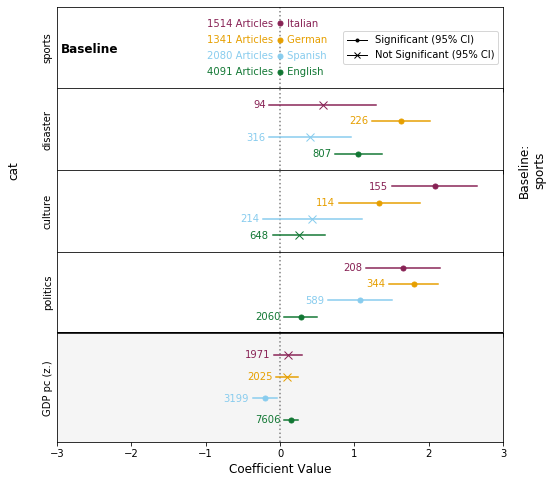

In [438]:
nb_fit_dict1 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_z ', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict1, ['cat', 'GDP_pc_z'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, x_limits=(-3, 3))

In [416]:
nb_fit_dict1_1 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log ', est_method='lbfgs',
                                                   output_lvl=0)

In [415]:
from regression import fit_regression_and_rename_coeffs_by_cat
fit_alpha2 = fit_regression_and_rename_coeffs_by_cat(df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log', type='nb', alpha=20)
fit_alpha2['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7601
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -89373.
Date:                Tue, 19 Apr 2022   Deviance:                       1568.8
Time:                        16:02:24   Pearson chi2:                 7.56e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.0924      0.472     19.281      0.000       8.168      10.017
cat[T.culture]      0.2889      0.189      1.526      0.127      -0.082       0.660
cat[T.disaster]     1.0901      0.177      6.160      0.000       0.743       1.437
cat[T.politics]     0.3051      0.121      2.525      0.012       0.068       0.542
GDP_pc_log          0.1218      0.046      2.648      0.008       0.032       0.212
===================================================================================
"""

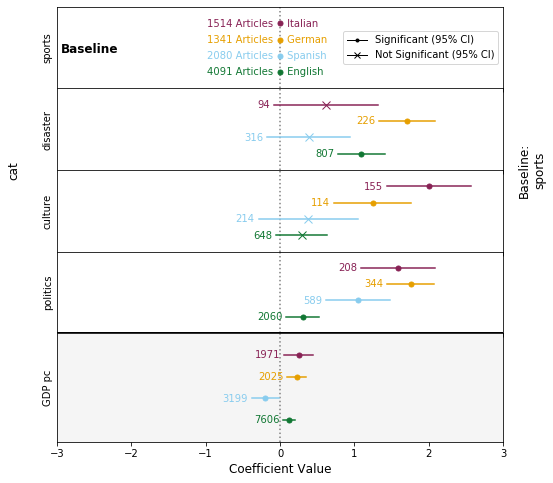

In [417]:
nb_fit_dict1_1 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log ', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict1_1, ['cat', 'GDP_pc_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, x_limits=(-3, 3))

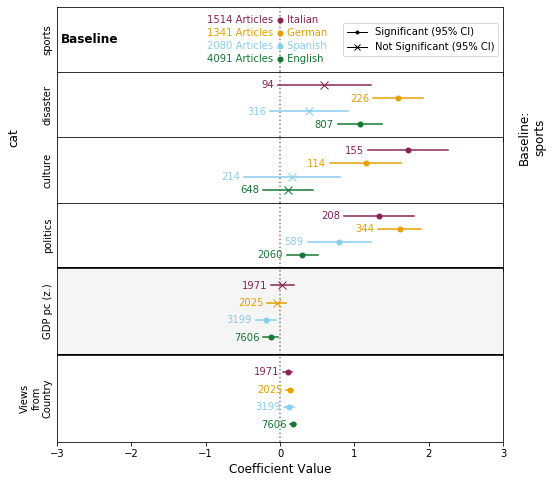

In [318]:
nb_fit_dict2_1 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_z + views_baseline_log', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict2_1, ['cat', 'GDP_pc_z', 'views_baseline_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, x_limits=(-3, 3))

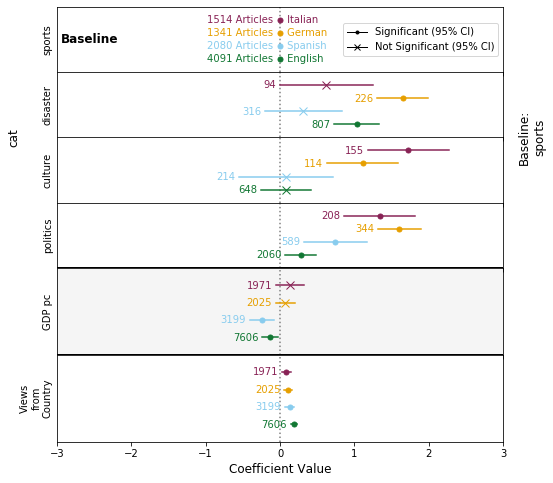

In [439]:
nb_fit_dict2_2 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + views_baseline_log', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict2_2, ['cat', 'GDP_pc_log', 'views_baseline_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, x_limits=(-3, 3))

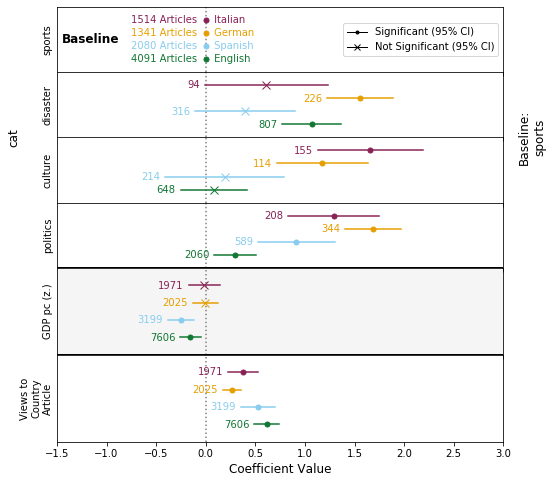

In [325]:
nb_fit_dict4_1 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_z  + view_country_article_log', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict4_1, ['cat', 'GDP_pc_z', 'view_country_article_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, x_limits=(-1.5, 3))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.443059185053624 (p=5.3035872150854896e-05)
Deviance: 1958.44 | Null-deviance: 2100.24
Pseudo ChiSq: 7684.03 | Good-Fit-ChiSq): 7803.92
Pseudo R² (1 - D/D_0) = 0.0675
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.0111
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 17.623222121301804 (p=5.171313591146289e-05)
Deviance: 708.78 | Null-deviance: 777.69
Pseudo ChiSq: 3531.44 | Good-Fit-ChiSq): 3325.57
Pseudo R² (1 - D/D_0) = 0.0886
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.1060
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.435026976987668 

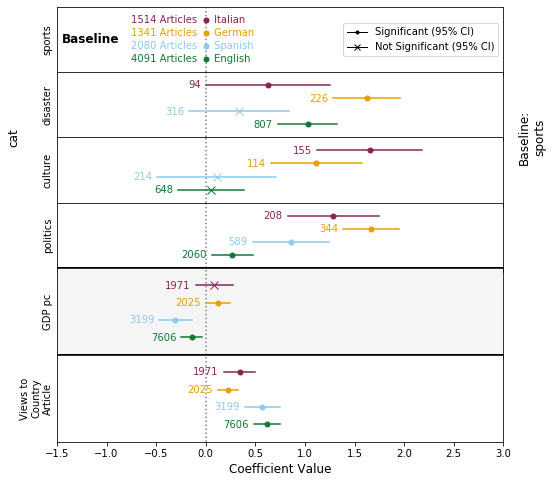

In [346]:
nb_fit_dict4_2 = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered, 
    'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log', 
    est_method='lbfgs', output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict4_2, ['cat', 'GDP_pc_log', 'view_country_article_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, x_limits=(-1.5, 3))

/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:485: RuntimeWarning: overflow encountered in true_divide
  score_factor = (self.endog - mu) / self.family.link.deriv(mu)
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:486: RuntimeWarning: invalid value encountered in true_divide
  score_factor /= self.family.variance(mu)


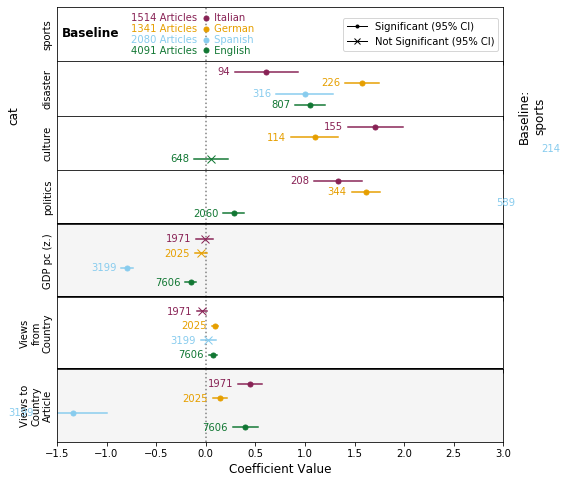

In [252]:
nb_fit_dict5_1 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_z + views_baseline_log + view_country_article_log', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict5_1, ['cat', 'GDP_pc_z', 'views_baseline_log', 'view_country_article_log'], baselines,
                                  cat_dict=cat_dict, label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, x_limits=(-1.5, 3))

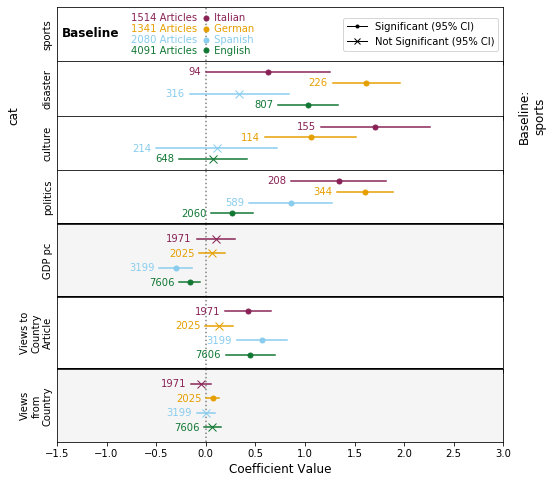

In [453]:
nb_fit_dict5_2 = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered, 
    'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log + views_baseline_log', 
    est_method='lbfgs', output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict5_2, ['cat', 'GDP_pc_log', 'view_country_article_log', 'views_baseline_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, x_limits=(-1.5, 3))

### Geographic Region

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 13.854295176366996 (p=0.000749142087126269)
Deviance: 2136.23 | Null-deviance: 2341.08
Pseudo ChiSq: 9090.54 | Good-Fit-ChiSq): 7796.83
Pseudo R² (1 - D/D_0) = 0.0875
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.1972
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 13.909264203933619 (p=5.445253509901457e-06)
Deviance: 826.75 | Null-deviance: 985.33
Pseudo ChiSq: 4338.47 | Good-Fit-ChiSq): 3318.43
Pseudo R² (1 - D/D_0) = 0.1609
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.3617
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 4.131823047892471 (p

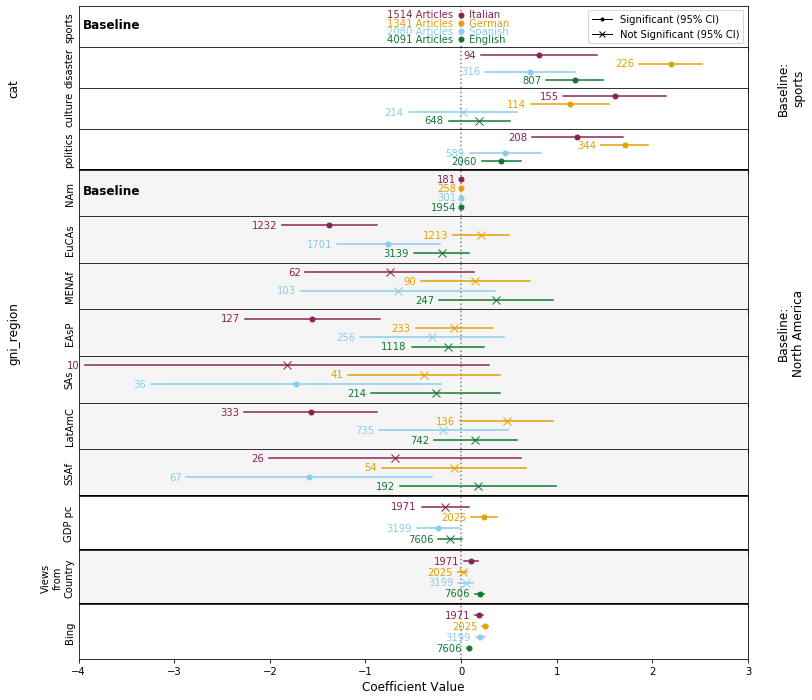

In [471]:
nb_fit_dict6_1 = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered, 
    'views_7_sum ~ C(cat, Treatment(reference="sports")) +  C(gni_region, Treatment(reference="North America")) + GDP_pc_log + views_baseline_log + bing_hits_log', 
    est_method='lbfgs', output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict6_1, ['cat', 'gni_region', 'GDP_pc_log', 'views_baseline_log', 'bing_hits_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, 
                                            x_limits=(-4, 3), figsize=(12,12))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.381783827726732 (p=0.00020509324685376727)
Deviance: 1966.30 | Null-deviance: 2108.61
Pseudo ChiSq: 9075.00 | Good-Fit-ChiSq): 7798.86
Pseudo R² (1 - D/D_0) = 0.0675
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.1949
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 16.884995135553044 (p=0.00843128240587719)
Deviance: 736.67 | Null-deviance: 811.69
Pseudo ChiSq: 5258.27 | Good-Fit-ChiSq): 3320.47
Pseudo R² (1 - D/D_0) = 0.0924
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.6494
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.615281112829973 (p

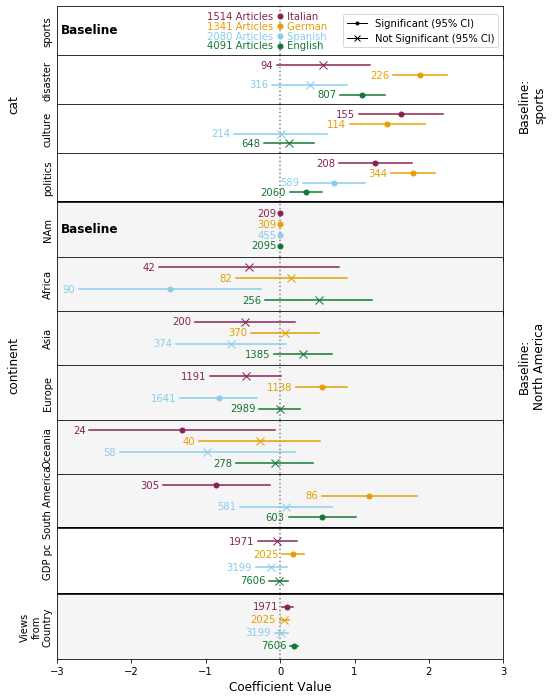

In [465]:
nb_fit_dict6_2 = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered, 
    'views_7_sum ~ C(cat, Treatment(reference="sports")) +  C(continent, Treatment(reference="North America")) + GDP_pc_log + views_baseline_log', 
    est_method='lbfgs', output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict6_2, ['cat', 'continent', 'GDP_pc_log', 'views_baseline_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, 
                                            x_limits=(-3, 3), figsize=(8,12))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 16.189302839554678 (p=0.0002814119796094814)
Deviance: 1893.99 | Null-deviance: 2003.43
Pseudo ChiSq: 9082.37 | Good-Fit-ChiSq): 7799.87
Pseudo R² (1 - D/D_0) = 0.0546
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.1957
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 16.794148375249925 (p=0.008254416011649909)
Deviance: 738.92 | Null-deviance: 816.08
Pseudo ChiSq: 5324.68 | Good-Fit-ChiSq): 3321.49
Pseudo R² (1 - D/D_0) = 0.0945
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.6697
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 6.538719774818342 (p

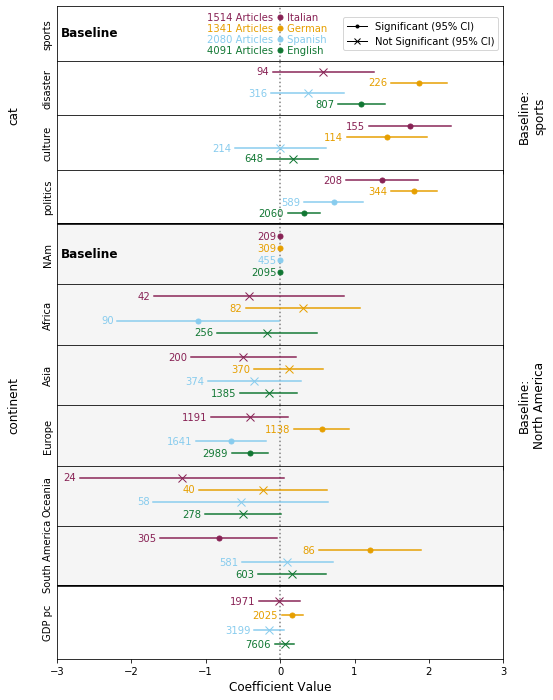

In [458]:
nb_fit_dict6_2 = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered, 
    'views_7_sum ~ C(cat, Treatment(reference="sports")) +  C(continent, Treatment(reference="North America")) + GDP_pc_log', 
    est_method='lbfgs', offset_col='views_baseline_log', output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict6_2, ['cat', 'continent', 'GDP_pc_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, 
                                            x_limits=(-3, 3), figsize=(8,12))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.480245477264958 (p=0.00022250755647966263)
Deviance: 1960.64 | Null-deviance: 2095.20
Pseudo ChiSq: 8754.77 | Good-Fit-ChiSq): 7802.91
Pseudo R² (1 - D/D_0) = 0.0642
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.1521
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 18.296880095672297 (p=0.010124162167358853)
Deviance: 694.38 | Null-deviance: 749.06
Pseudo ChiSq: 4881.03 | Good-Fit-ChiSq): 3324.55
Pseudo R² (1 - D/D_0) = 0.0730
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.5291
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.692047396474259 (

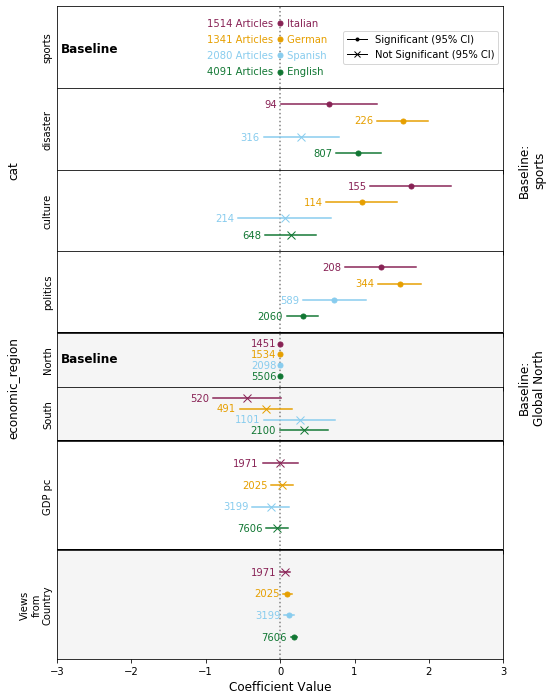

In [401]:
nb_fit_dict6_2 = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered, 
    'views_7_sum ~ C(cat, Treatment(reference="sports")) +  C(economic_region, Treatment(reference="Global North")) + GDP_pc_log + views_baseline_log', 
    est_method='lbfgs', output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict6_2, ['cat', 'economic_region', 'GDP_pc_log', 'views_baseline_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, label_sort=label_sort, include_counts=True, 
                                            x_limits=(-3, 3), figsize=(8,12))

## Corr and VIF analysis

In [261]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [472]:
df_vif.columns

Index(['const', 'event_id', 'pagetitle', 'event_date', 'economic_region',
       'country', 'continent', 'cat', 'categories', 'views_7_sum',
       'views_before_mean', 'views_before_sum', 'views_before_max',
       'views_before_min', 'views_before_median', 'views_before_increase',
       'list_views_7_days', 'diff_days', 'year', 'planed', 'surprising',
       'factor', 'page_creation', 'edits_7_sum', 'edits_before_min',
       'edits_before_mean', 'edits_before_max', 'edits_before_median',
       'edits_before_sum', 'code', 'bing_hits', 'gni_class', 'gni_region',
       'population', 'Country/Area', 'Year', 'GDP_pc', 'GDP', 'oecd',
       'date_month', 'views_baseline', 'in_code_lang', 'in_code_region',
       'views_baseline_cat', 'view_country_article', 'GDP_pc_z', 'gdp_z',
       'pop_z', 'views_baseline_z', 'view_country_article_z', 'bing_hits_z',
       'worldwide', 'view_country_article_log', 'views_baseline_log',
       'bing_hits_log', 'GDP_pc_log', 'GDP_log', 'population_log

In [468]:
df_vif = df_filtered.copy()
df_vif = add_constant(df_vif)
df_vif['gni_class_num'] = df_vif.gni_class.apply(lambda c: 0 if c=='L' else 1 if c=='LM' else 2 if c=='UM' else 3)
X = df_vif[['const', 'GDP_pc_log', 'population_log', 'views_baseline_log', 'bing_hits_log']]
pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
          index=X.columns, name='VIF')

const                 249.387213
GDP_pc_log              1.305277
population_log          1.444287
views_baseline_log      1.748060
bing_hits_log           1.028434
Name: VIF, dtype: float64

In [467]:
for code in df_filtered.code.unique():
    for cat in df_filtered.cat.unique():
        print()
        print(code, cat)
        print(df_filtered[(df_filtered.code==code) & (df_filtered.cat==cat)][['view_country_article', 'views_baseline', 'GDP_pc', 'population_log', 'bing_hits_log']].corr('spearman'))


en disaster
                      view_country_article  views_baseline    GDP_pc  \
view_country_article              1.000000        0.925033  0.699133   
views_baseline                    0.925033        1.000000  0.691207   
GDP_pc                            0.699133        0.691207  1.000000   
population_log                    0.745940        0.716498  0.278139   
bing_hits_log                     0.119781        0.135179  0.131836   

                      population_log  bing_hits_log  
view_country_article        0.745940       0.119781  
views_baseline              0.716498       0.135179  
GDP_pc                      0.278139       0.131836  
population_log              1.000000       0.028277  
bing_hits_log               0.028277       1.000000  

en culture
                      view_country_article  views_baseline    GDP_pc  \
view_country_article              1.000000        0.948884  0.703863   
views_baseline                    0.948884        1.000000  0.686374   
GD

In [ ]:
df_filtered.groupby('code').corr